# Eagle8 benchmarking
This notebook is only to run the benchmark on `eagle8`

In [1]:
using Revise
using CUDA
using Adapt
using Unitful
using Interpolations
using StaticArrays
import PhysicalConstants.CODATA2018: h, k_B, R_∞, c_0, m_e, m_u, e, ε_0, a_0
using BenchmarkTools
using PyPlot

using JLD2

using Vaf
using AtomicData

storage = "/mn/stornext/d10/data/chriskbl/" # Storage location

device!(0) # for eagle8

CuDevice(0): Tesla V100S-PCIE-32GB

In [2]:
include("calc_line_gpu.jl")
include("gpu_incline.jl")

Adapt.@adapt_structure Atmosphere1D
Adapt.@adapt_structure ExtinctionItpNLTE

In [3]:
HOME_PATH = "/uio/hume/student-u67/chriskbl"
include("int_from_pops_multi3d.jl")
# The atomosphere data
BASE_DIR = "/mn/stornext/u3/tiago/data/rhout/cb24bih/Halpha/s385/output"
HALF_DIR = "/mn/stornext/u3/tiago/data/cb24bih/multi3d"
mesh_file = joinpath(HALF_DIR, "mesh.cb24bih_s0385")
atmos_file = joinpath(HALF_DIR, "atm3d.cb24bih_s0385")
pops_file = joinpath(BASE_DIR, "out_pop")
ATOM_DIR = joinpath(HOME_PATH, ".julia/packages/AtomicData/Po3lP/data/atoms")
atom_file = joinpath(AtomicData.get_atom_dir(), "H_6.yaml")
atmos, h_pops = read_atmos_hpops_multi3d(mesh_file, atmos_file, pops_file)
atmos = read_atmos_rh("/mn/stornext/u3/tiago/data/cb24bih/bifrost_cb24bih_s385.ncdf")
bckgr_atoms = [
        "Al.yaml",
        "C.yaml",
        "Ca.yaml",
        "Fe.yaml",
        "H_6.yaml",
        "He.yaml",
        "KI.yaml",
        "Mg.yaml",
        "N.yaml",
        "Na.yaml",
        "NiI.yaml",
        "O.yaml",
        "S.yaml",
        "Si.yaml",
]
atom_files = [joinpath(AtomicData.get_atom_dir(), a) for a in bckgr_atoms]

h_atom = read_atom("/mn/stornext/u3/tiago/codes/rh-data/Atoms/yaml/H_6_multi.yaml")
my_line = h_atom.lines[5]
my_line_gpu = Adapt.adapt_structure(CuArray, my_line);
POPS_FILE = "/mn/stornext/u3/tiago/data/rhout/cb24bih/Halpha/s385/output/out_pop"
h_pops = read_pops_multi3d(POPS_FILE, 504, 504, 467, 6)
nl = permutedims(h_pops[:, :, :, 2], (3, 2, 1))
nu = permutedims(h_pops[:, :, :, 3], (3, 2, 1))

itp_cpu = get_σ_itp(atmos, my_line.λ0, atom_files)
atmos_gpu = Adapt.adapt_structure(CuArray, atmos)
#atmos1D_gpu = Adapt.adapt_structure(CuArray, atmos1D)
itp_gpu = Adapt.adapt_structure(CuArray{Float64}, itp_cpu)

const global_ndep = atmos.nz
const γ_mult = ustrip((h * c_0 / (4 * π)) |> u"J * nm")
const c_0u = ustrip(c_0)
const invSqrtPi = Float32(1. / sqrt(π));

my_line_gpu = Adapt.adapt_structure(CuArray, my_line)
nl_gpu = CuArray(nl)
nu_gpu = CuArray(nu);

## CPU Speed

In [5]:
intensity_cpu = zeros(Float32, (atmos.ny, atmos.nx, my_line.nλ));

In [ ]:
calc_line_cpu_single!(my_line, atmos, nu, nl, itp_cpu, intensity_cpu);

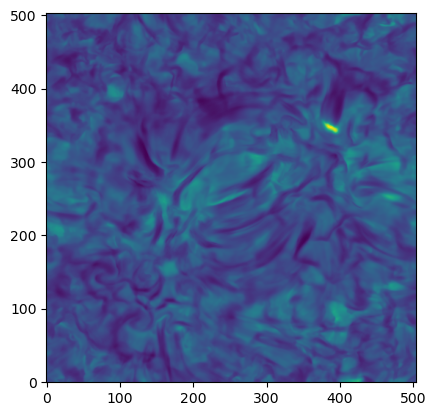

PyObject <matplotlib.image.AxesImage object at 0x7fc02a2f71f0>

In [13]:
imshow(intensity_cpu[:, :, 51])

In [8]:
@benchmark calc_line_cpu_single!(my_line, atmos, nu, nl, itp_cpu, intensity_cpu)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 693.734 s (0.00% GC) to evaluate,
 with a memory estimate of 2.93 MiB, over 1512 allocations.

In [6]:
intensity = zeros(Float32, (atmos.ny, atmos.nx, my_line.nλ));

In [7]:
calc_line_cpu!(my_line, atmos, nu, nl, itp_cpu, intensity);

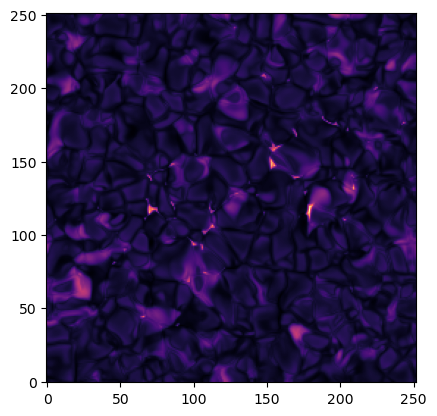

PyObject <matplotlib.image.AxesImage object at 0x7f43a69324d0>

In [ ]:
imshow(intensity[:, :, 1], cmap="magma")

In [7]:
@benchmark calc_line_cpu!($my_line, $atmos, $nu, $nl, $itp_cpu, $intensity)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 11.036 s (0.00% GC) to evaluate,
 with a memory estimate of 3.00 MiB, over 1865 allocations.

## GPU Speed

In [ ]:
intensity_gpu = CUDA.zeros(Float32, (atmos.ny, atmos.nx, my_line.nλ));

In [ ]:
# eagle
CUDA.@sync @cuda threads=(8,8) blocks=(63,63) calc_line_gpu!(
    my_line_gpu, atmos_gpu, nu_gpu, nl_gpu, itp_gpu, intensity_gpu);

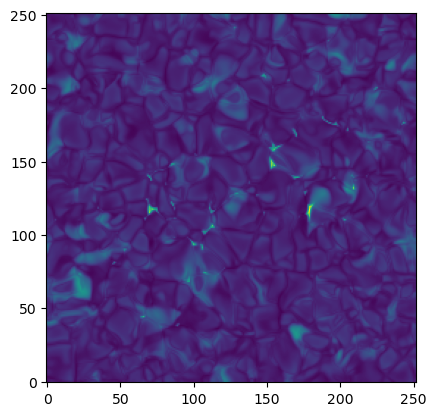

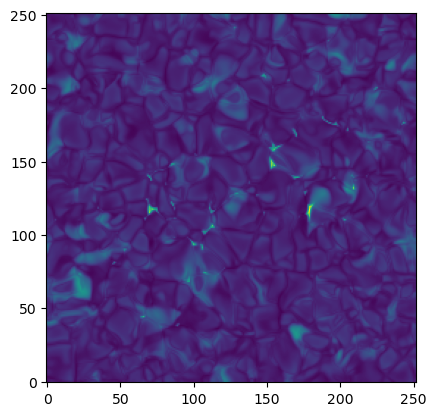

In [ ]:
intensity = Array(intensity_gpu)
imshow(intensity[:, :, 1])

In [17]:
CUDA.reclaim()

: 

In [13]:
@benchmark CUDA.@sync @cuda threads=(8,8) blocks=(63,63) calc_line_gpu!(
    $my_line_gpu, $atmos_gpu, $nu_gpu, $nl_gpu, $itp_gpu, $intensity_gpu)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.518 s …    2.518 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.518 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.518 s ± 110.891 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.52 s         Histogram: frequency by time         2.52 s <

 Memory estimate: 7.48 KiB, allocs estimate: 80.

: 

In [8]:
"""
This benchmark is to do the same calculation as the CPU version, but on the GPU.
Taking into account the time it takes to transfer the data to the GPU.
"""
function benchmark_gpu(my_line, atmos, nu, nl, itp_cpu, intensity_gpu)
    my_line_gpu = Adapt.adapt_structure(CuArray, my_line)
    atmos_gpu = Adapt.adapt_structure(CuArray, atmos)
    itp_gpu = Adapt.adapt_structure(CuArray{Float32}, itp_cpu)
    nu_gpu = CuArray(nu)
    nl_gpu = CuArray(nl)
    
    @benchmark CUDA.@sync @cuda threads=(8,8) blocks=(63,63) calc_line_gpu!(
        my_line_gpu, atmos_gpu, nu_gpu, nl_gpu, itp_gpu, intensity_gpu)
end


benchmark_gpu (generic function with 1 method)

In [9]:
intensity_gpu = CUDA.zeros(Float32, (atmos.ny, atmos.nx, my_line.nλ))
@benchmark benchmark_gpu(my_line, atmos, nu, nl, itp_cpu, intensity_gpu)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 16.769 s (5.88% GC) to evaluate,
 with a memory estimate of 1.13 MiB, over 15835 allocations.

: 

## Comparison

For the single thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 693.734 s (0.00% GC) to evaluate.
    with a memory estimate of 2.93 MiB, over 1512 allocations.
```

For the 16 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 44.105 s (0.00% GC) to evaluate.
    with a memory estimate of 1.61 MiB, over 1416 allocations.
```

For the 32 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 22.038 s (0.00% GC) to evaluate.
    with a memory estimate of 1.50 MiB, over 935 allocations.
```

For the 36 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 19.305 s (0.00% GC) to evaluate.
    with a memory estimate of 1.61 MiB, over 1416 allocations.
```

For the 64 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 11.036 s (0.00% GC) to evaluate.
    with a memory estimate of 1.61 MiB, over 1416 allocations.
```


For the 128 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 10.978 s (0.00% GC) to evaluate.
    with a memory estimate of 3.07 MiB, over 2269 allocations.
```

For the GPU version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 2.518 s (0.00% GC) to evaluate.
    with a memory estimate of 7.48 KiB, over 80 allocations.
```

For the GPU version with memory movement
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 16.769 s (0.00% GC) to evaluate.
    with a memory estimate of 7.48 KiB, over 80 allocations.
```


In [25]:
gpu_time = 3.376
cpu_time_single_thread = 746.513
cpu_time_32_thread = 23.835

23.835

Speedup one thread

In [26]:
println("Lower: ", cpu_time_single_thread / gpu_time)
println("Higher: ", cpu_time_single_thread / gpu_time)

Lower: 220.60076832151302
Higher: 221.5829623033541


Speedup 32 thread

In [27]:
println("Lower: ", cpu_time_32_thread / gpu_time)
println("Higher: ", cpu_time_32_thread / gpu_time)

Lower: 7.043439716312057
Higher: 7.07479964381122


# The Watt usage. 
### CPU: 
* [AMD EPYC2 7742](https://www.amd.com/en/products/cpu/amd-epyc-7742)
* Max. boost clock: 3.4GHz
* Default TDP: 225W


### GPU:
* [NVIDIA Tesla V100S](https://images.nvidia.com/content/tesla/pdf/Tesla-V100-PCIe-Product-Brief.pdf)
* Total board power: 250 W

Assume that both are running at maximum to get the upperbound limit

In [30]:
GPU_watt = 250 
CPU_watt = 225

GPU_energy = GPU_watt * gpu_time
CPU_energy_single_thread = CPU_watt * cpu_time_single_thread
CPU_energy_32_thread = CPU_watt * cpu_time_32_thread;

In [31]:
println("Single thread: ", CPU_energy_single_thread / GPU_energy)
println("32 thread: ", CPU_energy_32_thread / GPU_energy)

Single thread: 199.0111670616114
32 thread: 6.354117298578199
